<a href="https://colab.research.google.com/github/markvasin/deep_learning_exercise/blob/master/lab4/Lab4_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

!pip install ipython-autotime

%load_ext autotime

     |████████████████████████████████| 143kB 3.4MB/s 
  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=f78ca210ec9e581ae8fe713f8405c47a2b46c844f21e61aa249fbe5965dd0d7e
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


#Wide MLPs on MNIST#

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

time: 196 ms


##Loading MNIST data##

In [ ]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
time: 1.56 s


##MLP Model##

In [ ]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

time: 3.81 ms


##Training and Evaluating MLP models##

###Baseling model with 784 hidden nodes###

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Accuracy of MLP with 784 hidden nides')

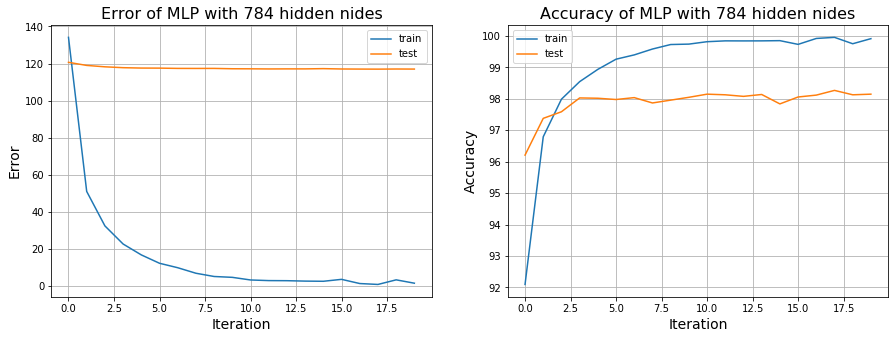

time: 1min 59s


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# build the model 
model = BaselineModel(784, 784, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

num_opoch = 20
e_train_plot = np.zeros((num_opoch, 1))
e_test_plot = np.zeros((num_opoch, 1))
acc_train_plot = np.zeros((num_opoch, 1))
acc_test_plot = np.zeros((num_opoch, 1))

# the epoch loop
for epoch in range(num_opoch):
    
    # training
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        training_loss += loss.item()

        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_train_plot[epoch] = training_loss
    acc_train_plot[epoch] = ((100.0 * correct.item()) / total)

    # testing
    model.eval()
    testing_loss = 0.0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        testing_loss += loss.item()
        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_test_plot[epoch] = testing_loss
    acc_test_plot[epoch] = ((100.0 * correct.item()) / total)
    print("Epoch %d" % epoch)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(e_train_plot, label='train')
ax1.plot(e_test_plot, label='test')
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Error", fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_title("Error of MLP with 784 hidden nides",fontsize=16)

ax2.plot(acc_train_plot, label='train')
ax2.plot(acc_test_plot, label='test')
ax2.set_xlabel("Iteration", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.set_title("Accuracy of MLP with 784 hidden nides",fontsize=16)

###MLP with 500000 hidden units###

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Accuracy of MLP with 784 hidden nides')

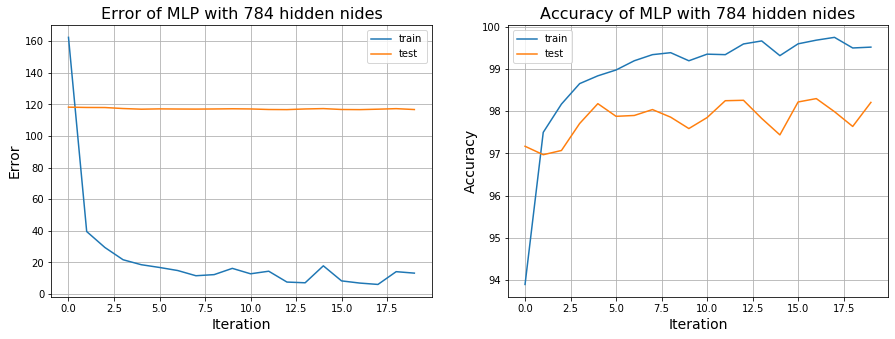

time: 35min 36s


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# build the model 
model = BaselineModel(784, 500000, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

num_opoch = 20
e_train_plot = np.zeros((num_opoch, 1))
e_test_plot = np.zeros((num_opoch, 1))
acc_train_plot = np.zeros((num_opoch, 1))
acc_test_plot = np.zeros((num_opoch, 1))

# the epoch loop
for epoch in range(num_opoch):
    
    # training
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        training_loss += loss.item()

        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_train_plot[epoch] = training_loss
    acc_train_plot[epoch] = ((100.0 * correct.item()) / total)

    # testing
    model.eval()
    testing_loss = 0.0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        testing_loss += loss.item()
        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_test_plot[epoch] = testing_loss
    acc_test_plot[epoch] = ((100.0 * correct.item()) / total)
    print("Epoch %d" % epoch)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(e_train_plot, label='train')
ax1.plot(e_test_plot, label='test')
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Error", fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_title("Error of MLP with 784 hidden nides",fontsize=16)

ax2.plot(acc_train_plot, label='train')
ax2.plot(acc_test_plot, label='test')
ax2.set_xlabel("Iteration", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.set_title("Accuracy of MLP with 784 hidden nides",fontsize=16)

###MLP with 10000 hidden units###

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Accuracy of MLP with 10000 hidden nides')

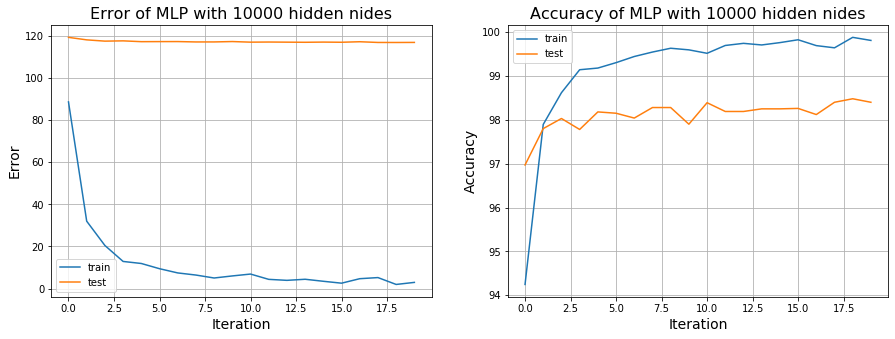

time: 2min 42s


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# build the model 
model = BaselineModel(784, 10000, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

num_opoch = 20
e_train_plot = np.zeros((num_opoch, 1))
e_test_plot = np.zeros((num_opoch, 1))
acc_train_plot = np.zeros((num_opoch, 1))
acc_test_plot = np.zeros((num_opoch, 1))

# the epoch loop
for epoch in range(num_opoch):
    
    # training
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        training_loss += loss.item()

        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_train_plot[epoch] = training_loss
    acc_train_plot[epoch] = ((100.0 * correct.item()) / total)

    # testing
    model.eval()
    testing_loss = 0.0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        testing_loss += loss.item()
        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_test_plot[epoch] = testing_loss
    acc_test_plot[epoch] = ((100.0 * correct.item()) / total)
    print("Epoch %d" % epoch)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(e_train_plot, label='train')
ax1.plot(e_test_plot, label='test')
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Error", fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_title("Error of MLP with 10000 hidden nides",fontsize=16)

ax2.plot(acc_train_plot, label='train')
ax2.plot(acc_test_plot, label='test')
ax2.set_xlabel("Iteration", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.set_title("Accuracy of MLP with 10000 hidden nides",fontsize=16)

###MLP with 100 hidden units###

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Accuracy of MLP with 100 hidden nodes')

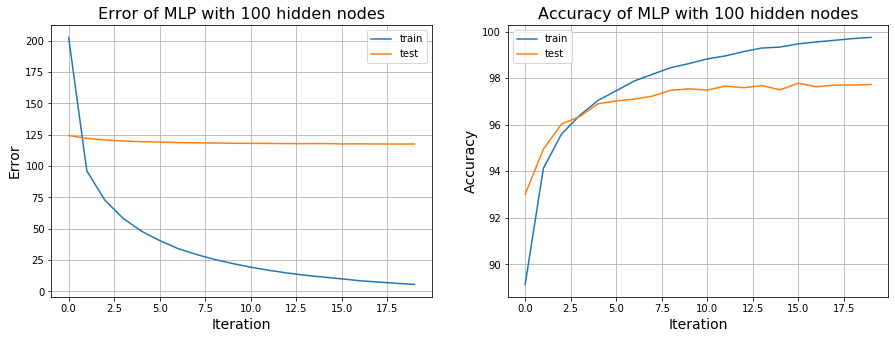

time: 2min


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# build the model 
model = BaselineModel(784, 100, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

num_opoch = 20
e_train_plot = np.zeros((num_opoch, 1))
e_test_plot = np.zeros((num_opoch, 1))
acc_train_plot = np.zeros((num_opoch, 1))
acc_test_plot = np.zeros((num_opoch, 1))

# the epoch loop
for epoch in range(num_opoch):
    
    # training
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        training_loss += loss.item()

        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_train_plot[epoch] = training_loss
    acc_train_plot[epoch] = ((100.0 * correct.item()) / total)

    # testing
    model.eval()
    testing_loss = 0.0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        testing_loss += loss.item()
        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_test_plot[epoch] = testing_loss
    acc_test_plot[epoch] = ((100.0 * correct.item()) / total)
    print("Epoch %d" % epoch)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(e_train_plot, label='train')
ax1.plot(e_test_plot, label='test')
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Error", fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_title("Error of MLP with 100 hidden nodes",fontsize=16)

ax2.plot(acc_train_plot, label='train')
ax2.plot(acc_test_plot, label='test')
ax2.set_xlabel("Iteration", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.set_title("Accuracy of MLP with 100 hidden nodes",fontsize=16)

###MLP with 1000 hidden units###

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Accuracy of MLP with 100 hidden nodes')

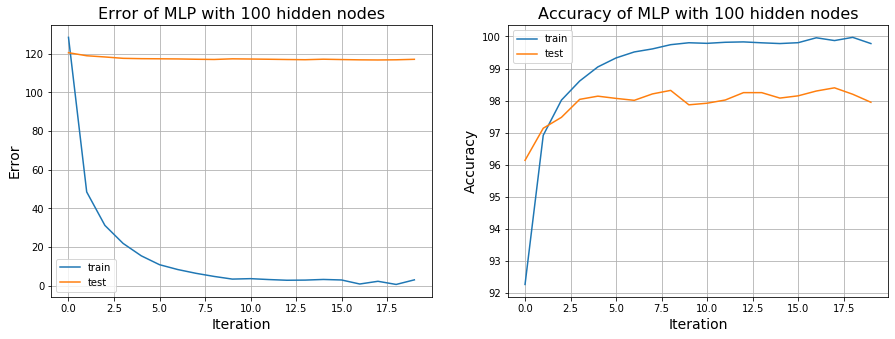

time: 1min 59s


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# build the model 
model = BaselineModel(784, 1000, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

num_opoch = 20
e_train_plot = np.zeros((num_opoch, 1))
e_test_plot = np.zeros((num_opoch, 1))
acc_train_plot = np.zeros((num_opoch, 1))
acc_test_plot = np.zeros((num_opoch, 1))

# the epoch loop
for epoch in range(num_opoch):
    
    # training
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        training_loss += loss.item()

        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_train_plot[epoch] = training_loss
    acc_train_plot[epoch] = ((100.0 * correct.item()) / total)

    # testing
    model.eval()
    testing_loss = 0.0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        testing_loss += loss.item()
        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_test_plot[epoch] = testing_loss
    acc_test_plot[epoch] = ((100.0 * correct.item()) / total)
    print("Epoch %d" % epoch)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(e_train_plot, label='train')
ax1.plot(e_test_plot, label='test')
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Error", fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_title("Error of MLP with 100 hidden nodes",fontsize=16)

ax2.plot(acc_train_plot, label='train')
ax2.plot(acc_test_plot, label='test')
ax2.set_xlabel("Iteration", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.set_title("Accuracy of MLP with 100 hidden nodes",fontsize=16)

###MLP with 5000 hidden unites###

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Accuracy of MLP with 5000 hidden nodes')

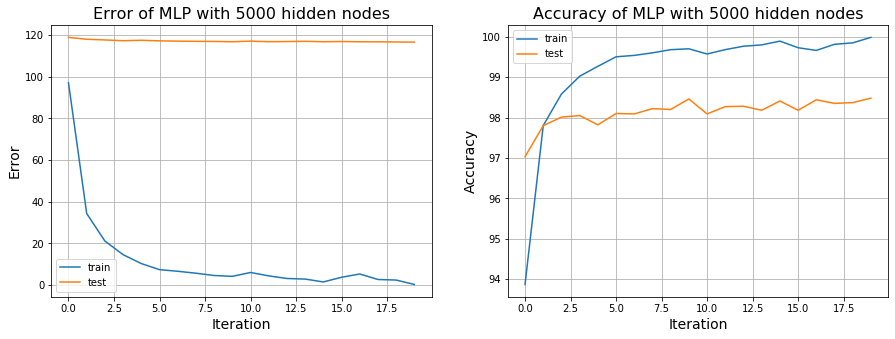

time: 2min 19s


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# build the model 
model = BaselineModel(784, 5000, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

num_opoch = 20
e_train_plot = np.zeros((num_opoch, 1))
e_test_plot = np.zeros((num_opoch, 1))
acc_train_plot = np.zeros((num_opoch, 1))
acc_test_plot = np.zeros((num_opoch, 1))

# the epoch loop
for epoch in range(num_opoch):
    
    # training
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        training_loss += loss.item()

        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_train_plot[epoch] = training_loss
    acc_train_plot[epoch] = ((100.0 * correct.item()) / total)

    # testing
    model.eval()
    testing_loss = 0.0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        testing_loss += loss.item()
        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_test_plot[epoch] = testing_loss
    acc_test_plot[epoch] = ((100.0 * correct.item()) / total)
    print("Epoch %d" % epoch)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(e_train_plot, label='train')
ax1.plot(e_test_plot, label='test')
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Error", fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_title("Error of MLP with 5000 hidden nodes",fontsize=16)

ax2.plot(acc_train_plot, label='train')
ax2.plot(acc_test_plot, label='test')
ax2.set_xlabel("Iteration", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.set_title("Accuracy of MLP with 5000 hidden nodes",fontsize=16)

###MLP with 20000 hidden units###

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Accuracy of MLP with 20000 hidden nodes')

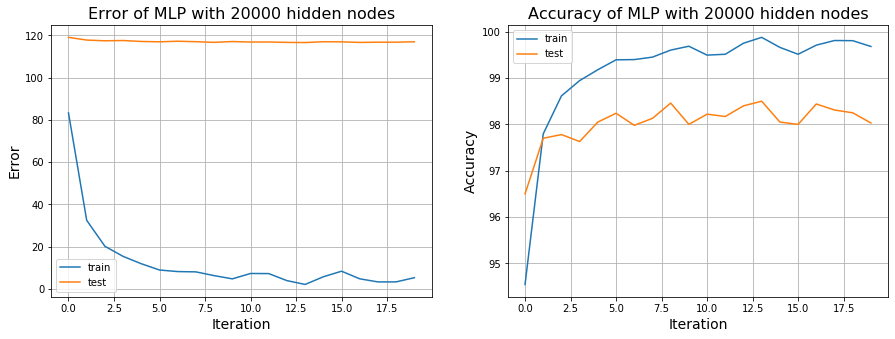

time: 3min 7s


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# build the model 
model = BaselineModel(784, 20000, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

num_opoch = 20
e_train_plot = np.zeros((num_opoch, 1))
e_test_plot = np.zeros((num_opoch, 1))
acc_train_plot = np.zeros((num_opoch, 1))
acc_test_plot = np.zeros((num_opoch, 1))

# the epoch loop
for epoch in range(num_opoch):
    
    # training
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        training_loss += loss.item()

        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_train_plot[epoch] = training_loss
    acc_train_plot[epoch] = ((100.0 * correct.item()) / total)

    # testing
    model.eval()
    testing_loss = 0.0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        testing_loss += loss.item()
        prediction = torch.argmax(outputs, dim=1)
        correct += (prediction == labels).float().sum()
        total += labels.shape[0]
    
    e_test_plot[epoch] = testing_loss
    acc_test_plot[epoch] = ((100.0 * correct.item()) / total)
    print("Epoch %d" % epoch)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(e_train_plot, label='train')
ax1.plot(e_test_plot, label='test')
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Error", fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_title("Error of MLP with 20000 hidden nodes",fontsize=16)

ax2.plot(acc_train_plot, label='train')
ax2.plot(acc_test_plot, label='test')
ax2.set_xlabel("Iteration", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.set_title("Accuracy of MLP with 20000 hidden nodes",fontsize=16)

##Wide MLPs on MNIST##

**How wide does the network need to be (how many hidden
units) before it overfits on the MNIST training dataset?
Provide rational.**

We observe that there is significance difference between Train and Test Loss and Hence there is High probability that we might have overfit.
The loss of test set doesn't goes down along with training loss.
A rule of thumb definition is that over fitting occurs when your train accuracy keeps improving while your validation accuracy stops improving (or even starts getting worse).
The main issue is that these very wide, shallow networks are very good at memorization, but not so good at generalization.

 **Why they might be so?**

if you train the network with every possible input value, a super wide network could eventually memorize the corresponding output value that you want.

https://datascience.stackexchange.com/questions/19874/why-doesnt-overfitting-devastate-neural-networks-for-mnist-classification

A neural network with a hidden layer has universality: given enough hidden units, it can approximate any function. This is a frequently quoted – and even more frequently, misunderstood and applied – theorem.

It’s true, essentially, because the hidden layer can be used as a lookup table.